# DAMP: Discord-Aware Matrix Profile

Authors in [DAMP](https://www.cs.ucr.edu/~eamonn/DAMP_long_version.pdf) presented a method for anomaly detection that is scalable, and it can be used in offline and online mode. 

A subsequence is anomaly if its distance to its (left) nearest neighbor is larger than the distance of any other subsequences to their (left) nearest neighbors. This paper considers the left nearest neighbors so to not miss catching twin-freak cases, i.e. two anomalies that are similar to each other.

For now, let us consider a time series `T` and let's say we are interested in finding anomaly in an offline setting. For this, we assume that the first few points in `T` are just for training, and we start discovering anomalies for the remaining points. Hence, for a given `split_index`, the train part is `T[:split_index]` and the anomalies should be coming from `T[split_index:]`.

# import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import stumpy
import time

from stumpy import core
from tqdm import tqdm

# core idea

**How can we find top-1 discord of `T` in the offline mode?**<br> 
To find discord, one can compute (left) matrix profile array and locate the index where the array has the maximum finite value. That is the start index of the anomaly. What `DAMP` does is to obtain an approx. left matrix profile whose maximum is exact! This means that it can still give us the correct (top-1) discord.

**How does DAMP work?**<br>
Let's say we have time series `T` and we start exploring this time series from left, and now we are at index `i`. At this moment, let's say the best-so-far discord score (i.e. distance between discord and its nearest neighbor) is known to be `discord_score`. In a naive approach, one can explore all the left neighbors of the subsequence `S_i = T[i: i + m]` and find its nearest neighbor. DAMP, however, uses an early abondoning approach. So, as soon as it finds a (left) neighbor whose distance to `S_i` is less than `discord_score`, `DAMP` stop exploring the remaining of the left neighbors because the distance between `S_i` to its nearest neighbor would be also less than `discord_score`. This is called `BackwardProcessing`. To take advantage of rolling-based computation, the `BackwardProcessing` does not explore one neighbor at a time. Instead, it explores them chunk by chunk using the MASS algorithm.

We can go to the next index, i.e. `i+1`, and do the same process. That means, for the next subsequence, we need to run `BackwardProcessing` at least for one chunk using MASS algorithm. But what if we can find a way to prune some the forthcoming subsequences? So, we only need to do `BackwardProcessing` for the ones that are not pruned and can be considered as eligible discords. To prune the forthcoming subsequences, we can use MASS on the query `S_i` and find its distances to the subsequences on its right. Note that for those subsequences, `S_i` is considered as one of their left neighbors! So, if the distance between `S_i` and any one of those subsequences become less than `discord_score`, those subsequences can be prunned and ignored later. So, when `DAMP` process reaches one of those subsequences, they can just be skipped.

## Naive approach

In [3]:
def naive_DAMP(T, m, split_index):
    """
    Compute the top-1 discord in `T`, where the subsequence discord resides in T[split_index:]
    
    Parameters
    ----------
    T : numpy.ndarray
        A time series
        
    m : int
        Window size
    
    split_index : int
        The split index between train and test.
    
    Returns
    -------
    PL : numpy.ndarry
        The left matrix profile value
        
    discord_score : float
        The discord's score, which is the distance between discord and its nearest neighbor
        
    discord_idx : int
        The start index of discord
    """
    stumpy.config.STUMPY_EXCL_ZONE_DENOM = 1
    excl_zone = int(np.ceil(m / stumpy.config.STUMPY_EXCL_ZONE_DENOM))
    
    mp = stumpy.stump(T, m)
    IL = mp[:, 2].astype(np.int64)
    IL[:split_index] = -1
    
    PL = np.full_like(IL, np.inf, dtype=np.float64)
    for i, nn_i in enumerate(IL):
        if nn_i >= 0:
            PL[i] = np.linalg.norm(core.z_norm(T[i : i + m]) - core.z_norm(T[nn_i : nn_i + m]))
    
    PL_modified = np.where(PL==np.inf, np.NINF, PL)
    discord_idx = np.argmax(PL_modified)
    discord_score = PL_modified[discord_idx]
    if discord_score == np.NINF:
        discord_idx = -1
        
    return PL, discord_score, discord_idx

In [4]:
seed = 100
np.random.seed(seed)

T = np.random.rand(10000)
m = 50
split_index = 200

PL, discord_score, discord_index = naive_DAMP(T, m, split_index)

print('discord_score: ', discord_score)
print('discord_index: ', discord_index)

discord_score:  8.500883427933504
discord_index:  209


## DAMP approach

In [5]:
def _foreward_processing(
    T, 
    m,  
    M_T, 
    Σ_T, 
    T_subseq_isconstant, 
    excl_zone, 
    query_idx, 
    discord_score, 
    is_subseq_pruned,
):
    """
    Prune forthcoming subsequences so that they become ineligible as discords
    
    Paramaters
    ----------
    T : numpy.ndarray
        The time series 
    
    m : int
        Window size
        
    M_T : numpy.ndarray
        The sliding mean
        
    Σ_T : numpy.ndarray
        The sliding standard deviation
        
    T_subseq_isconstant : numpy.ndarray
        A numpy boolean array whose i-th element indicates whether the subsequence
        `T[i : i+m]` is constant (True)
    
    excl_zone : int
        exclusion zone
    
    query_idx : int
        The start index of the subsequence of interest
    
    discord_score : float
        The best-so-far discord score
        
    is_subseq_pruned : np.ndarray
        A boolean numpy array that indicate whether a subsequence is pruned for
        being considered as discord
        
    Returns
    -------
    is_subseq_pruned : numpy.ndarray
        This is the updated version of `is_subseq_pruned` provided as one of the arguments.
        A numpy boolean array that indicates whether a subsequence is pruned (True) or not.
    """    
    lookahead = np.power(2, int(np.ceil(np.log(m) / np.log(2))))
    
    start = query_idx
    stop = min(start + lookahead, len(T))
    if stop - start >= m:
        QT = core.sliding_dot_product(T[query_idx : query_idx + m], T[start : stop])
        dist_profile = core._mass(
            T[query_idx : query_idx + m],
            T[start : stop],
            QT=QT,
            μ_Q=M_T[query_idx],
            σ_Q=Σ_T[query_idx],
            M_T=M_T[start : stop - m + 1],
            Σ_T=Σ_T[start : stop - m + 1],
            Q_subseq_isconstant=T_subseq_isconstant[query_idx],
            T_subseq_isconstant=T_subseq_isconstant[start : stop - m + 1],
        )
        
        core.apply_exclusion_zone(dist_profile, 0, excl_zone, np.inf)

        IDX = start + np.flatnonzero(dist_profile < discord_score)
        is_subseq_pruned[IDX] = True

    return is_subseq_pruned


def _backward_processing(
    T, 
    m, 
    M_T, 
    Σ_T, 
    T_subseq_isconstant, 
    excl_zone, 
    query_idx, 
    discord_score
):
    """
    Compute the approx. left matrix profile value for subsequence `T[query_idx:query_idx+m]`
    and update discord_score
    
    Parameters
    ----------
    T : numpy.ndarray
        The time series 
    
    m : int
        Window size
        
    M_T : np.ndarray
        The sliding mean
        
    Σ_T : np.ndarray
        The sliding standard deviation
    
    T_subseq_isconstant : numpy.ndarray
        A numpy boolean array whose i-th element indicates whether the subsequence
        `T[i : i+m]` is constant (True)
    
    excl_zone : int
        exclusion zone

    query_idx : int
        The start index of the subsequence of interest
    
    discord_score : float
        The best-so-far discord score
        
    Returns
    -------
    left_nn_distance : float
        Left matrix profile value for subsequence i
    
    discord_score : float
        The best-so-far distance computed as discord
    """
    left_nn_distance = np.inf
    prefix = np.power(2, int(np.ceil(np.log(m) / np.log(2))))
    
    excl_zone_st = query_idx - excl_zone
    stop_idx = query_idx + m
    # Although we analyze subsequences chunk by chunk, the maximum
    # number of chunks/iterations cannot exceed `query_idx`, which is
    # the number of subsequences before query_idx.
    for _ in range(query_idx):   
        if left_nn_distance < discord_score:
            break
        start_idx = max(0, stop_idx - prefix)
        QT = core.sliding_dot_product(
            T[query_idx : query_idx + m], 
            T[start_idx : stop_idx],
        )
        dist_profile = core._mass(
            T[query_idx : query_idx + m],
            T[start_idx : stop_idx],
            QT=QT,
            μ_Q=M_T[query_idx],
            σ_Q=Σ_T[query_idx],
            M_T=M_T[start_idx : stop_idx - m + 1],
            Σ_T=Σ_T[start_idx : stop_idx - m + 1],
            Q_subseq_isconstant=T_subseq_isconstant[query_idx],
            T_subseq_isconstant=T_subseq_isconstant[start_idx : stop_idx - m + 1],
            )
        
        if stop_idx >= excl_zone_st:
            idx = max(0, excl_zone_st - start_idx)
            dist_profile[idx:] = np.inf
            
        # following line is left for future reference. It can be used... 
        # if stop_idx remains at `query_idx + m`
        # core.apply_exclusion_zone(dist_profile, len(dist_profile)-1, excl_zone, np.inf)
        
        left_nn_distance = min(left_nn_distance, np.min(dist_profile))
        
        if start_idx == 0:
            discord_score = max(discord_score, left_nn_distance)
            break
            
        prefix = 2 * prefix
        stop_idx = start_idx + m
    
    return left_nn_distance, discord_score
        
                
def DAMP(T, m, split_index):  # Add param `T_subseq_isconstant`  
    """
    Compute approx. left matrix profile
    
    Parameters
    ----------
    T : numpy.ndarray
        A time series
    
    m : int
        Window size
    
    split_index : int
        location of split point between train and test. The data `T[:i]`
        is considered as train and the remaining, i.e. `T[i:]` is test.
    
    Returns
    -------
    PL : numpy.ndarry
        The left matrix profile value
        
    discord_score : float
        The discord's score, which is the distance between discord and its nearest neighbor
        
    discord_idx : int
        The start index of discord
    """
    stumpy.config.STUMPY_EXCL_ZONE_DENOM = 1  # according to paper, excl_zone is `m`
    excl_zone = int(np.ceil(m / stumpy.config.STUMPY_EXCL_ZONE_DENOM))
    
    T, M_T, Σ_T, T_subseq_isconstant = core.preprocess(T, m)
    
    l = len(T) - m + 1
    PL = np.full(l, np.inf, dtype=np.float64) 
    is_subseq_pruned = np.full(l, 0, dtype=bool)
    
    discord_score = np.NINF 
    for i in tqdm(range(split_index, l)):
        if is_subseq_pruned[i]:
            PL[i] = PL[i-1]
        else:
            PL[i], discord_score = _backward_processing(T, m, M_T, Σ_T, T_subseq_isconstant, excl_zone, i, discord_score)
            is_subseq_pruned = _foreward_processing(T, m, M_T, Σ_T, T_subseq_isconstant, excl_zone, i, discord_score, is_subseq_pruned)
        
    PL_modified = np.where(PL==np.inf, np.NINF, PL)
    discord_idx = np.argmax(PL_modified)
    discord_score = PL_modified[discord_idx]
    
    if discord_score == np.NINF:
        discord_idx = -1
        
    return PL, discord_score, discord_idx

In [6]:
PL, discord_score, discord_idx = DAMP(T, m, split_index)

print('discord value: ', discord_score)
print('discord at index: ', discord_idx)

100%|███████████████████████████████████████████████████████████| 9751/9751 [00:04<00:00, 2225.22it/s]

discord value:  8.500883427933498
discord at index:  209


# Reproducing Fig. 3 of paper (Anomaly in ECG data)

In [7]:
from scipy.io import loadmat

data = loadmat("DAMP_data/A_60-second snippet of an ECG.mat") 
data

{'__header__': b'MATLAB 5.0',
 '__version__': '1.0',
 '__globals__': [],
 'val': array([[  37,   39,   36, ..., -113, -114, -117],
        [  29,   28,   25, ...,    6,    5,    7]], dtype=int16)}

In [8]:
T = data['val'].flatten().astype(np.float64)
print(f"T has length: {len(T)}")

T has length: 30000


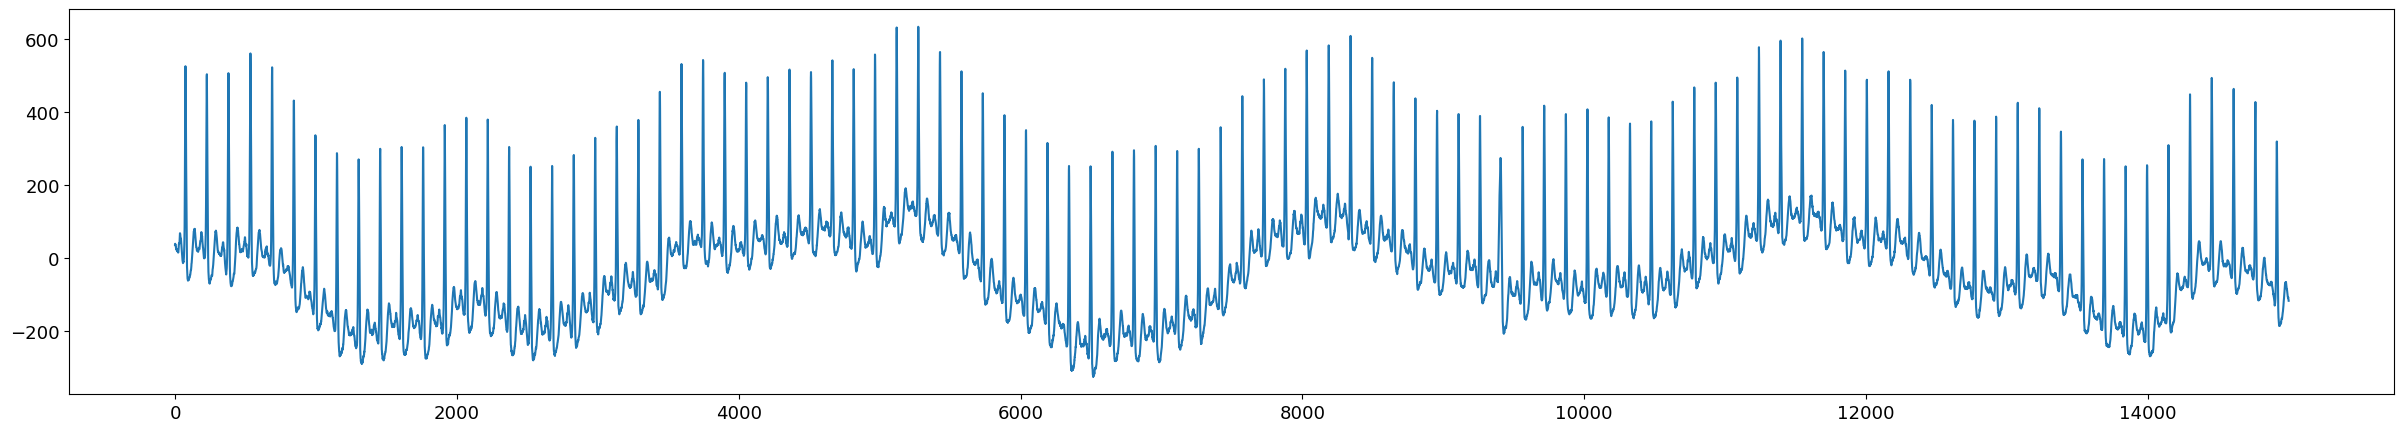

In [9]:
T = T[:15000] # similar to the length considered in the paper
plt.figure(figsize=(30, 5))
plt.plot(T)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

As observed, it is hard to locate the anomaly. Let's find it.

In [10]:
# `m` is provided in the supporting webpage. 
# see: https://sites.google.com/view/discord-aware-matrix-profile/reproducibility?authuser=0
m = 150   
split_index = 500  # rough value based on visual inspection of figure in the paper

PL_ref, discord_score_ref, discord_idx_ref = naive_DAMP(T, m, split_index)
print('discord_score_ref: ', discord_score_ref)
print('discord_idx_ref: ', discord_idx_ref)

discord_score_ref:  7.774100500490462
discord_idx_ref:  9262


In [11]:
PL_comp, discord_score_comp, discord_idx_comp = DAMP(T, m, split_index)
print('discord_score_comp: ', discord_score_ref)
print('discord_idx_comp: ', discord_idx_ref)

100%|█████████████████████████████████████████████████████████| 14351/14351 [00:05<00:00, 2456.42it/s]

discord_score_comp:  7.774100500490462
discord_idx_comp:  9262


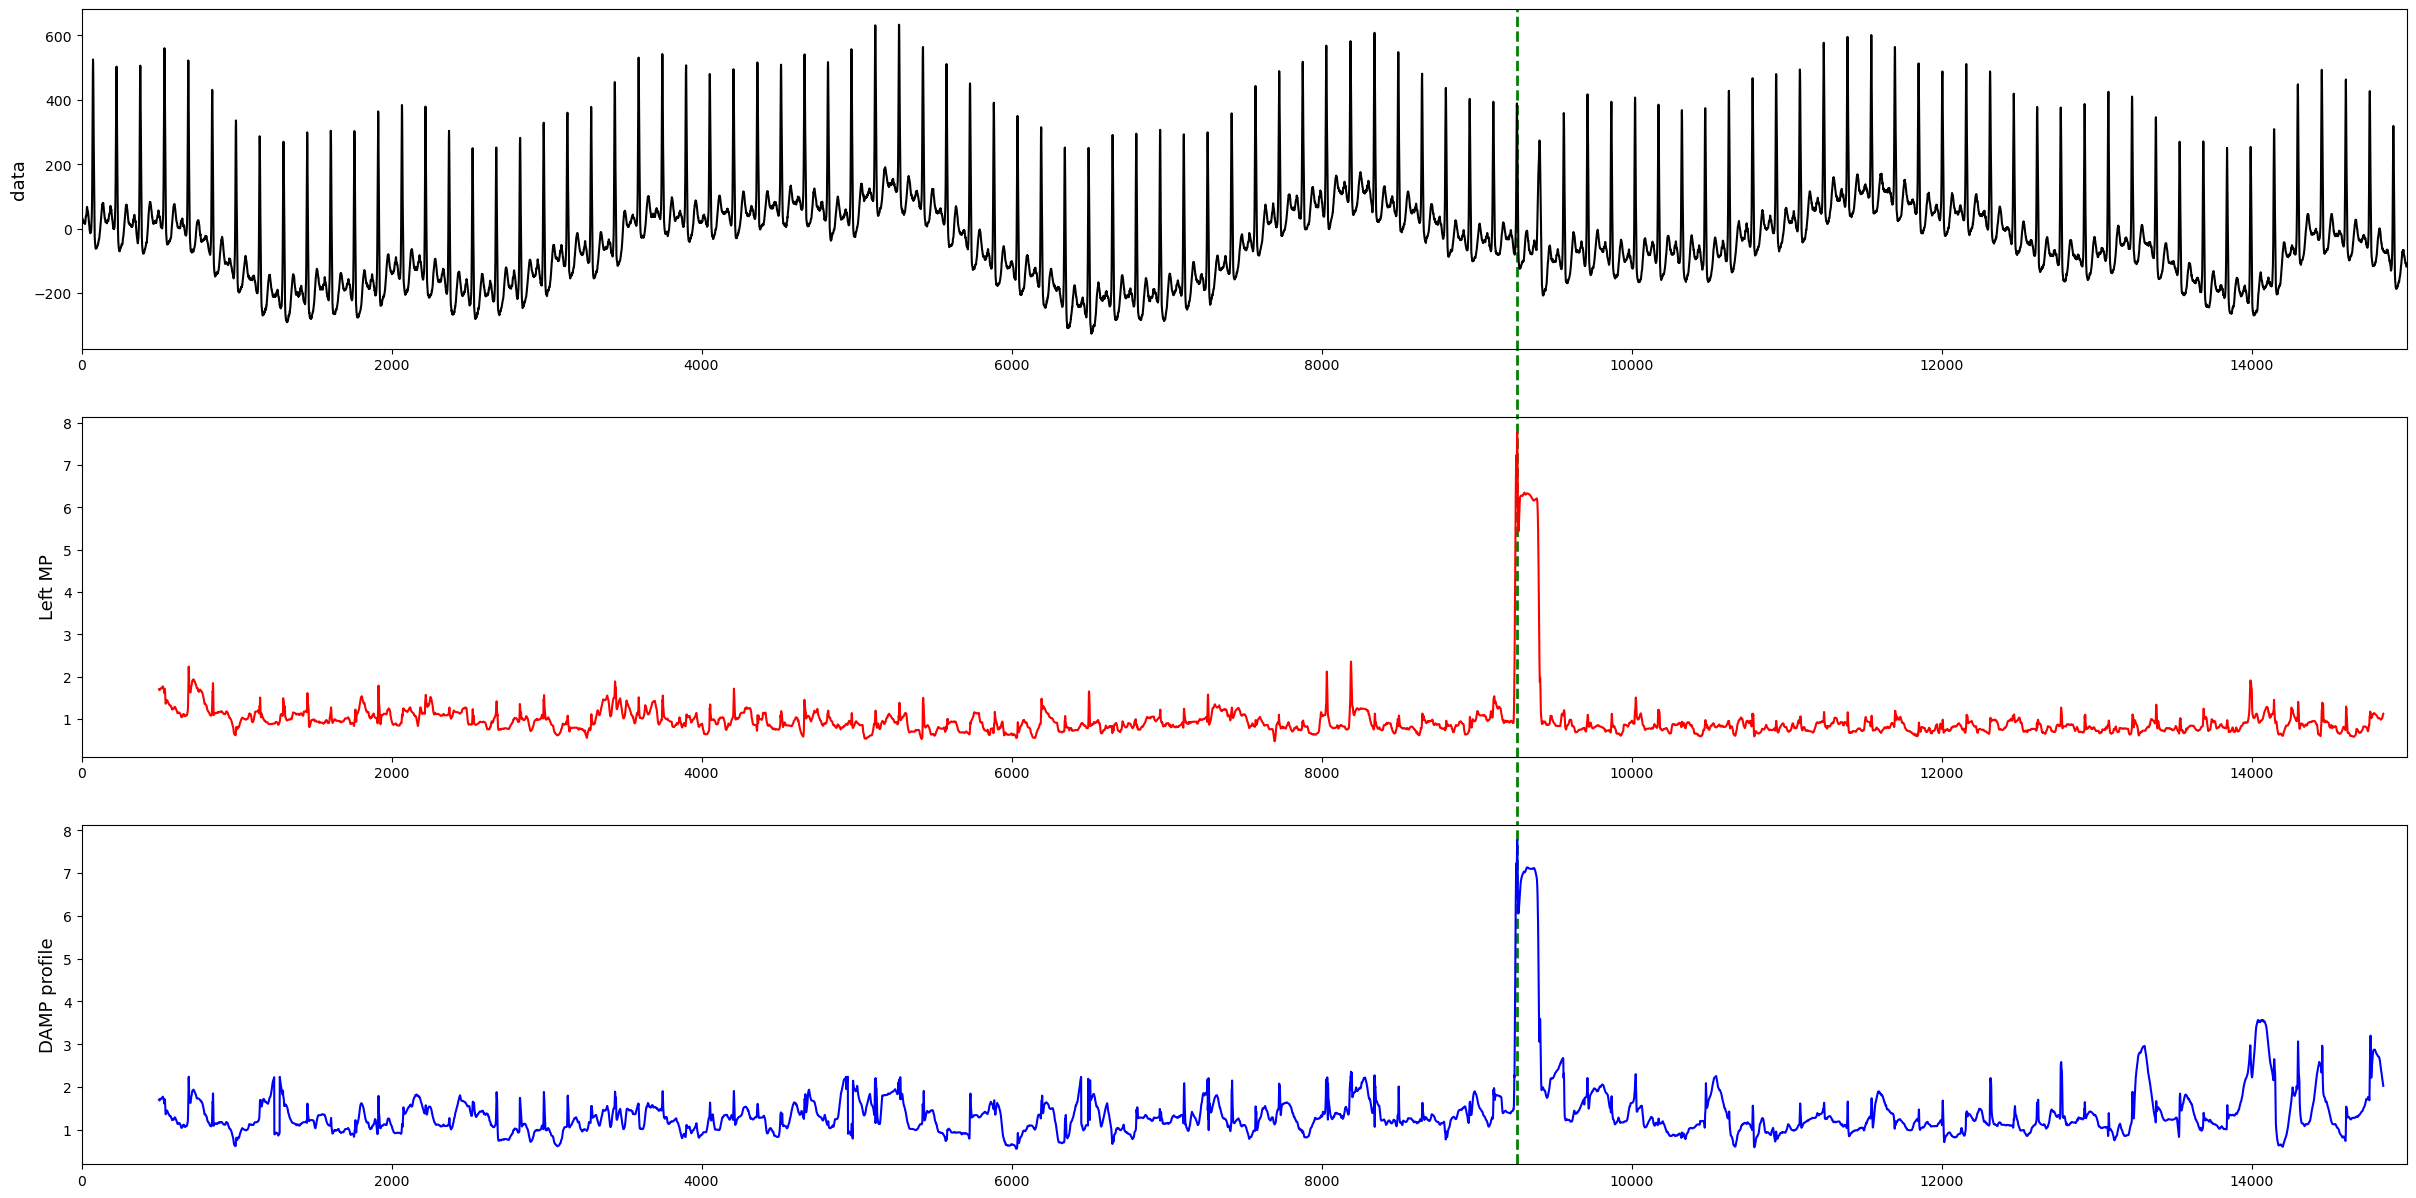

In [12]:
fig, axs = plt.subplots(nrows=3, figsize=(30, 15))

axs[0].plot(T, color='k')
axs[0].set_xlim(0, 15000)

axs[1].plot(PL_ref, color='r')
axs[1].set_xlim(0, 15000)

axs[2].plot(PL_comp, color='b')
axs[2].set_xlim(0, 15000)

axs[0].axvline(x=discord_idx_comp,ymin=-1,ymax=1,c="g",linewidth=2, linestyle='--', zorder=0, clip_on=False)
axs[1].axvline(x=discord_idx_comp,ymin=-1,ymax=1,c="g",linewidth=2, linestyle='--', zorder=0, clip_on=False)
axs[2].axvline(x=discord_idx_comp,ymin=0,ymax=1,c="g",linewidth=2, linestyle='--', zorder=0, clip_on=False)

axs[0].set_ylabel('data', fontsize=13)
axs[1].set_ylabel('Left MP', fontsize=13)
axs[2].set_ylabel('DAMP profile', fontsize=13)

plt.show()

As observed, the global maximum of `DAMP profile` is exact and that is enough to get the top-1 discord.

## Reproducing Fig. 2 of paper (Anomaly in electrical motor data)

In [13]:
data = loadmat("DAMP_data/bearing_time_series.mat") 
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Dec  6 22:32:16 2021',
 '__version__': '1.0',
 '__globals__': [],
 'testdata': array([[0.14566727],
        [0.09779636],
        [0.05485636],
        ...,
        [0.14053091],
        [0.09553636],
        [0.09019455]])}

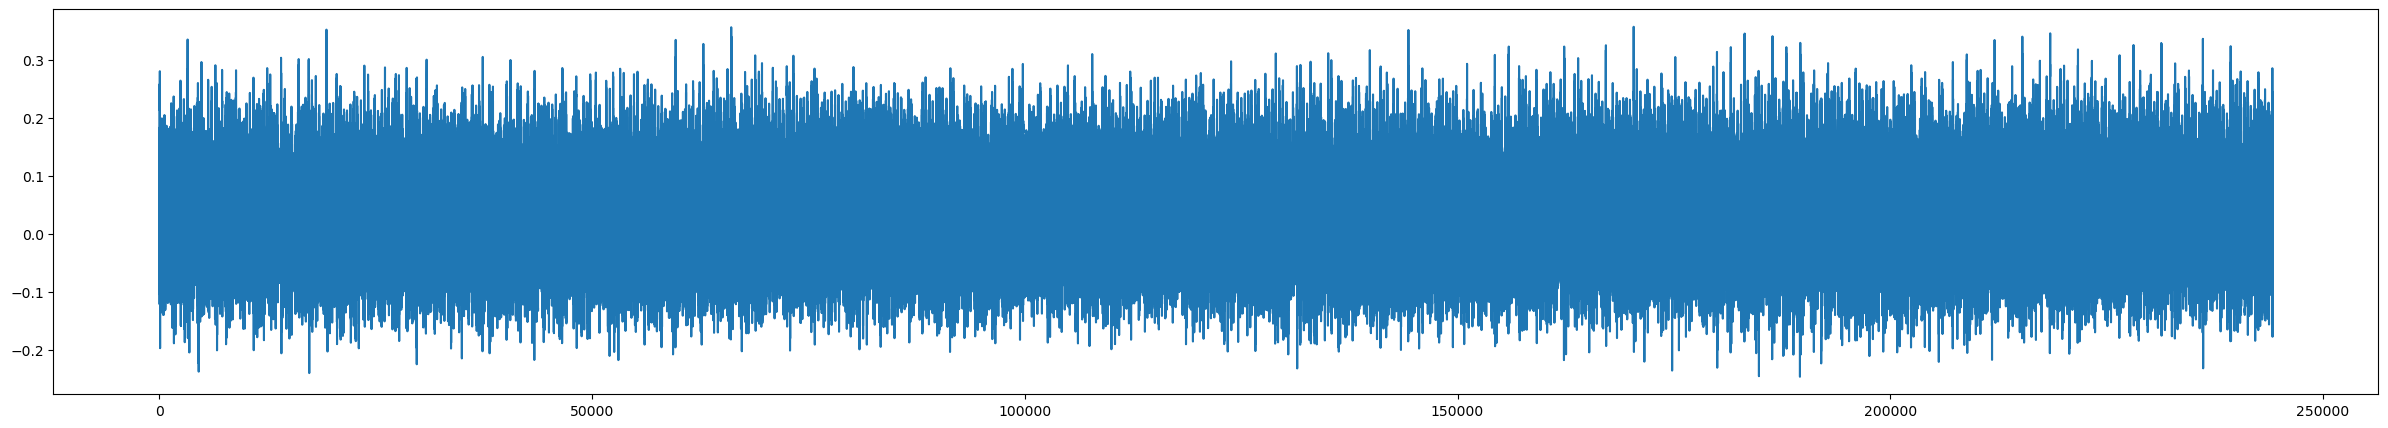

In [14]:
T = data['testdata'].flatten().astype(np.float64)
plt.figure(figsize=(30, 5))
plt.plot(T)
plt.show()

In [15]:
m = 300  # according to supporting page
split_index = 5000  # rough value based on visual inspection of figure in the paper

PL, discord_score, discord_idx = DAMP(T, m, split_index)

100%|███████████████████████████████████████████████████████| 238890/238890 [03:03<00:00, 1300.35it/s]


In [16]:
print('discord located at index: ', discord_idx)

discord located at index:  49881


In [17]:
# naive
# tic = time.time()
# PL, discord_score, discord_index = naive_DAMP(T, m, split_index)
# toc = time.time()

# print('running time: ', toc - tic)

The computed index `49881` matches the index provided in the supporting webpage. <br>
see [this slide of powerpoint](https://docs.google.com/presentation/d/1tQQfKuKrOa3j5-WJ9peoYfZGOnJbBcl9/edit#slide=id.p35)

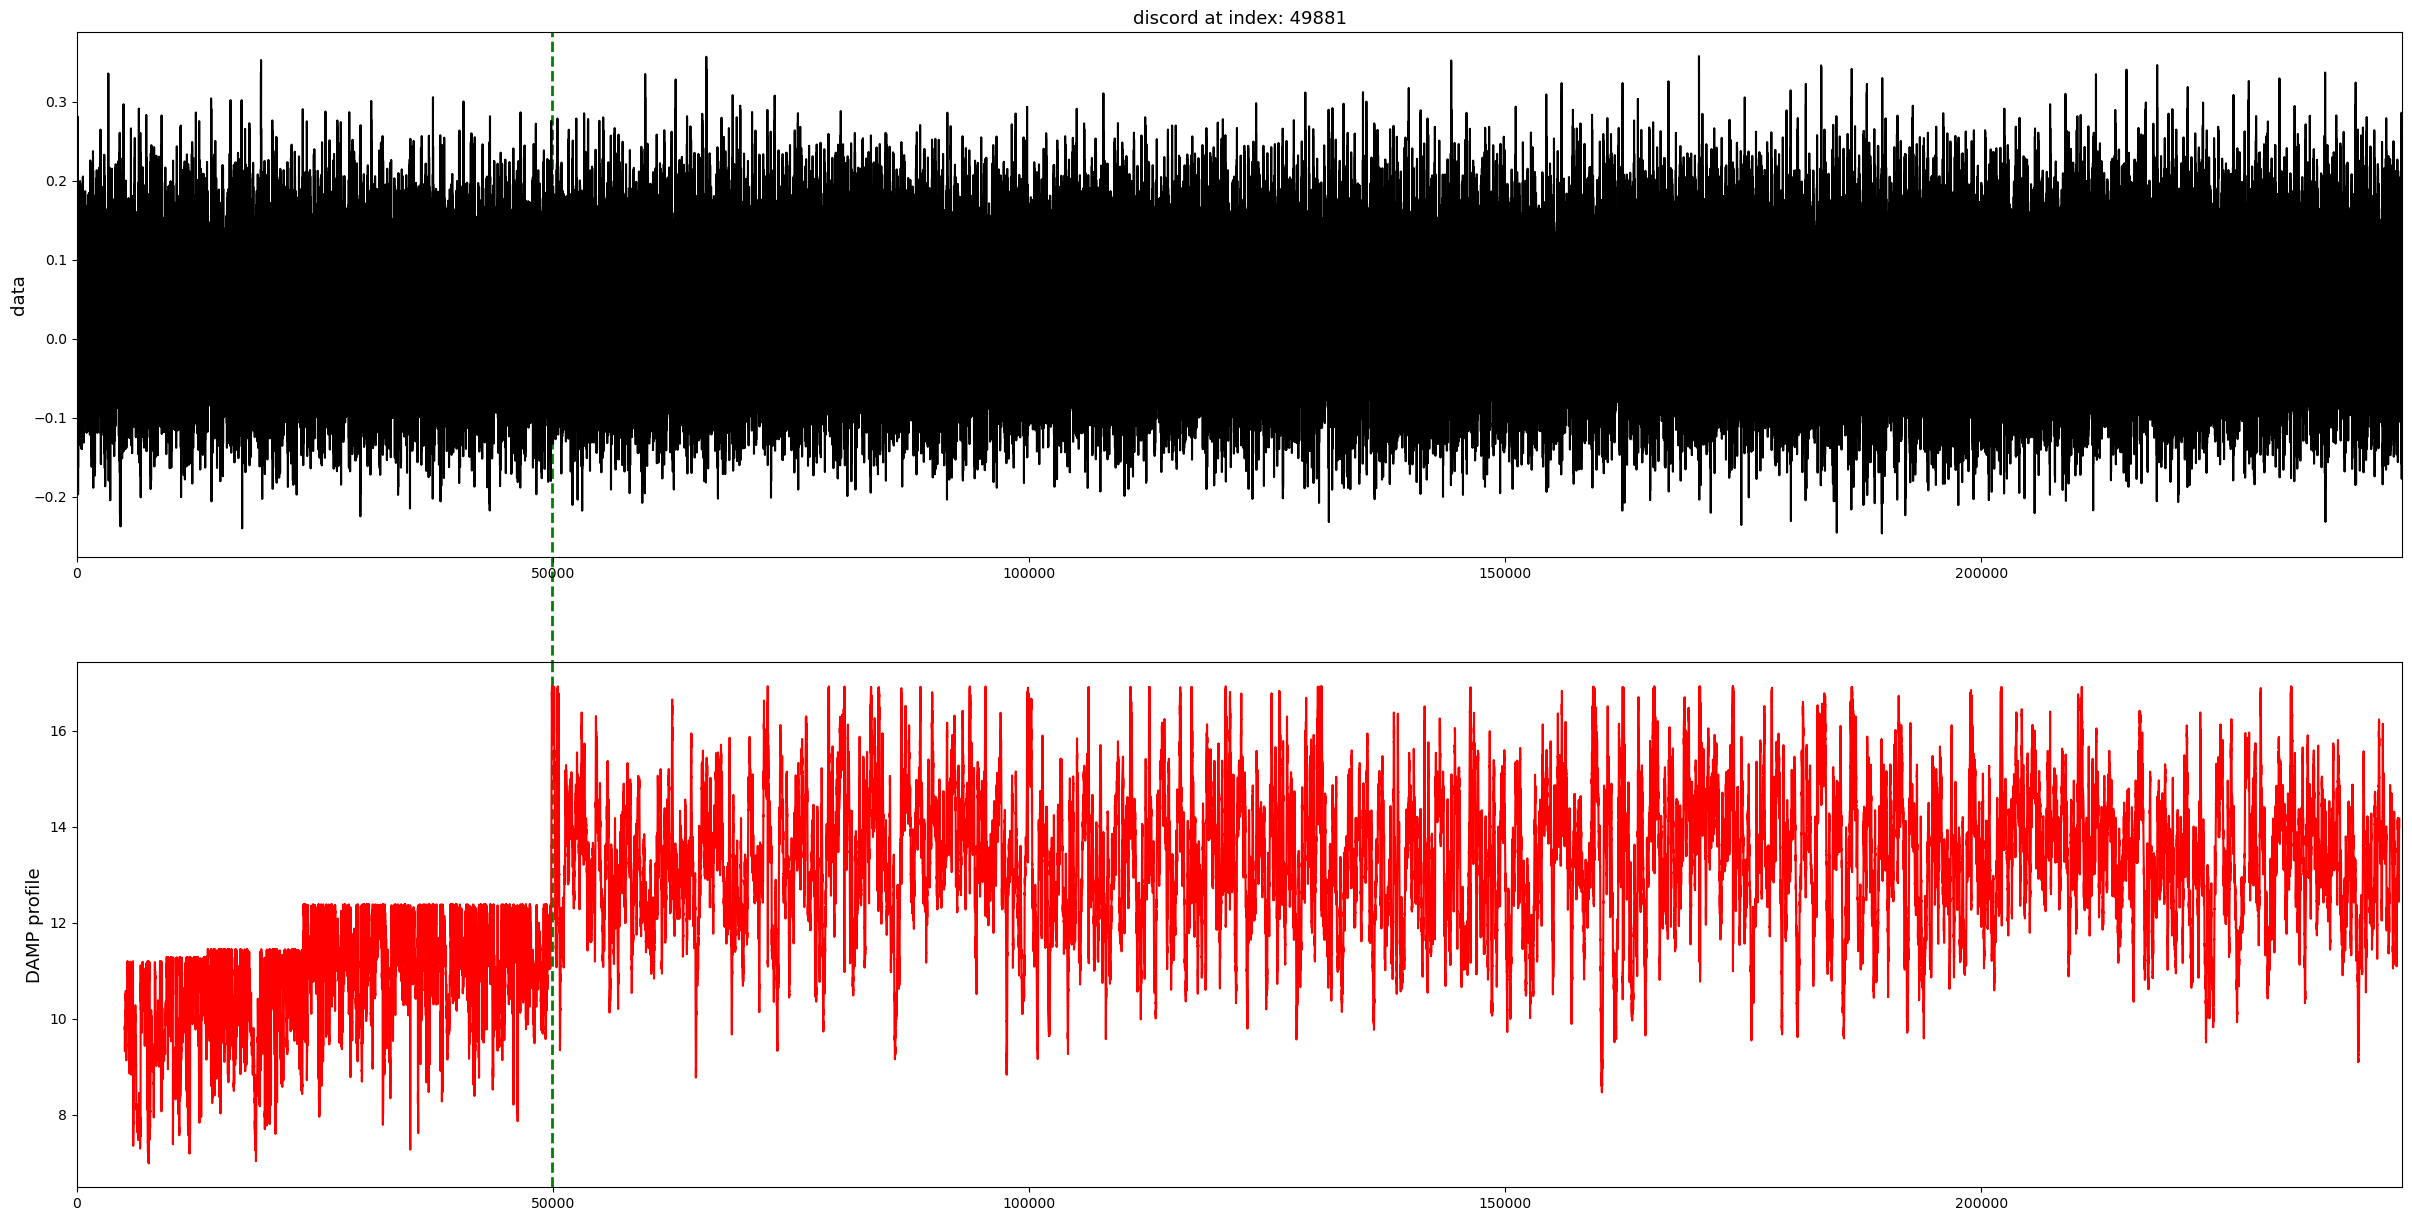

In [44]:
fig, axs = plt.subplots(nrows=2, figsize=(30, 15))

axs[0].plot(T, color='k')
axs[0].set_xlim(0, len(T))

axs[1].plot(PL, color='r')
axs[1].set_xlim(0, len(T))

axs[0].axvline(x=discord_idx,ymin=-1,ymax=1,c="g",linewidth=2, linestyle='--', zorder=0, clip_on=False)
axs[1].axvline(x=discord_idx,ymin=0,ymax=1,c="g",linewidth=2, linestyle='--', zorder=0, clip_on=False)

axs[0].set_ylabel('data', fontsize=13)
axs[1].set_ylabel('DAMP profile', fontsize=13)

axs[0].set_title(f'discord at index: {discord_idx}', fontsize=13)
plt.show()